# **Permuatation**

Permuatation is a resampling technique used in statistical analysis to estimate the sampling distribution of a statistic and make inferences about population parameters. It provides a flexible and data-driven approach, particularly **valuable when traditional assumptions for statistical tests are not fully met or when the sample size is small**.

Unlike traditional methods, Permuatation is non-parametric and **does not rely on specific distributional assumptions**. By randomly sampling without replacement from the available data, it generates an empirical sampling distribution of the statistic of interest. This **enables estimation of variability, and hypothesis testing** without strict assumptions about the data distribution.

In this notebook, we will explore the concept of bootstrapping,  demonstrate its application in statistical analysis and compare it to a two-sample t-test. We will cover generating bootstrap samples, estimating confidence intervals, performing hypothesis tests, and interpreting results. By the end, you will have a solid understanding of bootstrapping and its benefits, empowering you to apply this technique confidently in your own data analysis.

### **Overview of when to use Permuatation:**
1. When the sample size is 30 or less and the population standard deviation is unknown.
1. Assumptions (for parametric approaches) not met
1. Test something different than (mean, median)

### **Drawbacks:**
1. Does not support Confidence Intervals for true population parameter

In [50]:
# Importing Libraries
from scipy import stats as stat
from sklearn import datasets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### **``Loading and Visualizing the data``**

In [51]:
iris_data = datasets.load_iris()
iris_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [52]:
target_dict = {0 : 'Setosa', 1 : "versicolor", 2 : "virginica"}

data = pd.DataFrame(data = iris_data.data, columns = iris_data.feature_names)
data['target'] = iris_data.target
data['target'] = data['target'].replace(target_dict)
data = data.drop(columns = ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] )
data.head()

,sepal length (cm),target
0,5.1,Setosa
1,4.9,Setosa
2,4.7,Setosa
3,4.6,Setosa
4,5.0,Setosa


In [53]:
data.groupby('target').agg(['mean', 'median'])

sepal length (cm)       
                        mean median
target                             
Setosa                 5.006    5.0
versicolor             5.936    5.9
virginica              6.588    6.5

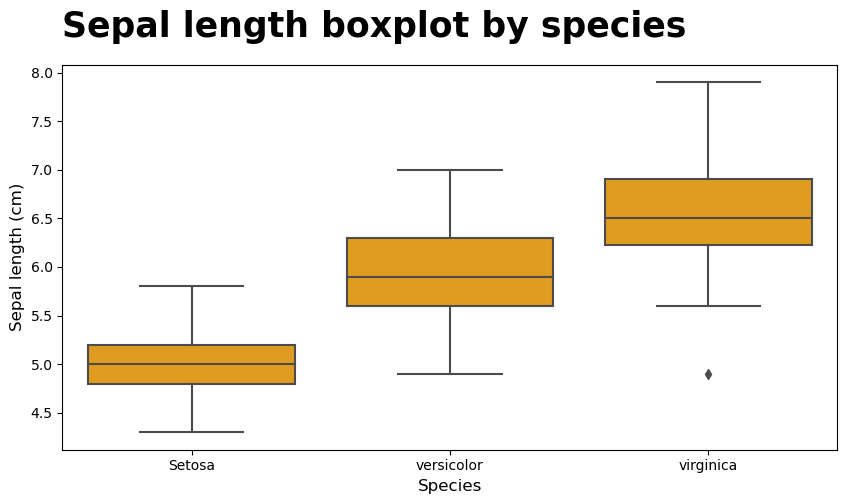

In [54]:
plt.figure(figsize=(10,5))

sns.boxplot(data = data,  x = 'target', y= 'sepal length (cm)', color = 'orange')

plt.title('Sepal length boxplot by species', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.ylabel('Sepal length (cm)', size= 12)
plt.xlabel('Species', size= 12)

plt.show()
# Separating the data
virginica = data[data['target'] == 'virginica']['sepal length (cm)']
versicolor = data[data['target'] == 'versicolor']['sepal length (cm)']

### **``Permutation:``** Hypothesis Test for difference in means

**Hypothesy:** Virginica sepal length (cm) median is different than versicolor sepal length (cm) mean

- $H_0$: Me<sub>virginica</sub> - Me<sub>versicolor</sub> = 0
- $H_1$: Me<sub>virginica</sub> - Me<sub>versicolor</sub> ≠ 0

In [55]:
# Calculating 
observed_test_stat = virginica.median() - versicolor.median()
observed_test_stat

0.5999999999999996

In [56]:
# Number of permutations
n_permutations = 50000
# List of permutation test-statistic
list_permutations = []
# List of probability (bootstrap_test_stat >= oberseved_test_stat)
stat = []
# Sample bootstrap means from 1 & 2
sample_medians = []
permutation_array = np.concatenate((virginica.values, versicolor.values)) # Concatenating two populations


for _ in range(n_permutations):

    # Generate sample permutation
    l = np.random.permutation(permutation_array)
    
    # Splitting the sample permutation in the two population
    sample_1 = l[:len(virginica)]
    sample_2 = l[len(virginica):]
    
    # Calculating Sample boostrap mean for both population
    median_1 = np.median(sample_1)
    median_2 = np.median(sample_2)
    
    # Appending the sample boostrap median
    sample_medians.append((median_1, median_2))
    
    # Calculate the boostrap test-statistic
    bott_test_stat = median_1 - median_2
    
    # Append the boostrap test-statistic
    list_permutations.append(bott_test_stat)
      
    # Comparison
    stat.append(abs(bott_test_stat) >= abs(observed_test_stat))

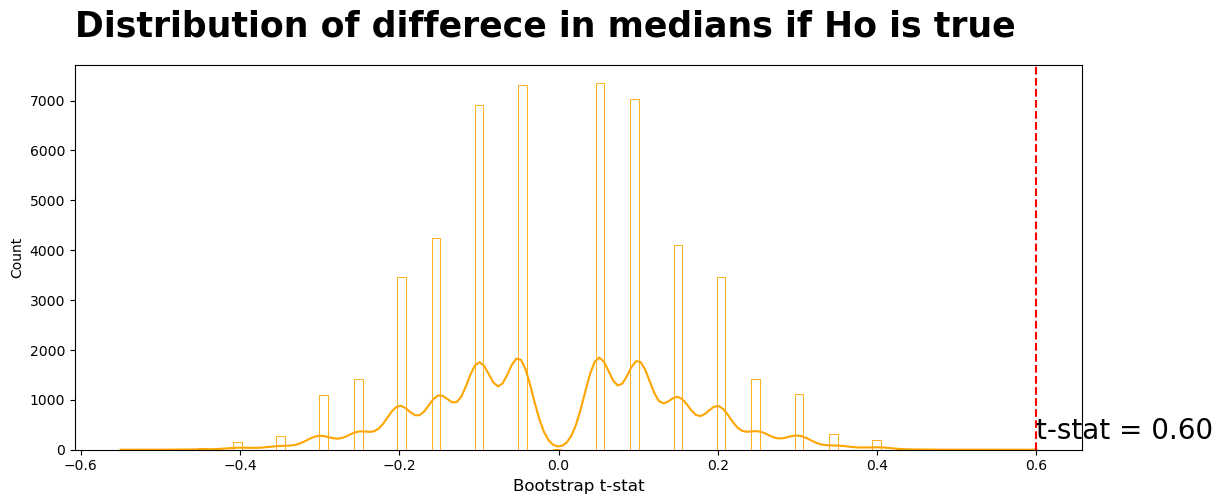

In [57]:
plt.figure(figsize=(13,5))

sns.histplot(x =list_permutations, color= 'orange', fill = False, kde= True)

plt.title('Distribution of differece in medians if Ho is true', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.xlabel('Bootstrap t-stat', size= 12)
plt.axvline(x=observed_test_stat, color='red', linestyle='--', label='t-Statistic')
plt.text(observed_test_stat, 100, f't-stat = {observed_test_stat:.2f}', size=20, color='black', verticalalignment='bottom', horizontalalignment='left')

plt.show()

In [58]:
# The variable stat contains the comparison |bootstrap test stat| >= |observed test stat|
print(f'There are {np.array(stat).sum()} bootrstap t-stat that are greater or equal to the observed t-test')

There are 1 bootrstap t-stat that are greater or equal to the observed t-test


In [59]:
p_value = np.array(stat).sum() / n_permutations
p_value

2e-05

**Result:** Reject $H_0$

**Interpretation:**  The probability of observing a difference in median of 0.60, or a more extreme difference, if $H_0$ is true, is approximately 0%. This indicates strong evidence of a significant difference between the sepal length (cm) medians of virginica and versicolor. Specifically, the median sepal length of virginica is greater than the median sepal length of versicolor.

### **``What if we increase 0.4 cm in versicolor? Will that still be significant?``**

**Hypothesy:** Virginica sepal length (cm) median is different than versicolor sepal length (cm) + 0.4 median

- $H_0$: Me<sub>virginica</sub> - Me<sub>versicolor + 0.4</sub> = 0
- $H_1$: Me<sub>virginica</sub> - Me<sub>versicolor + 0.4</sub> ≠ 0

In [60]:
data[data['target']=="versicolor"].head()

,sepal length (cm),target
50,7.0,versicolor
51,6.4,versicolor
52,6.9,versicolor
53,5.5,versicolor
54,6.5,versicolor


In [61]:
data.loc[data['target'] == "versicolor",'sepal length (cm)'] = data.loc[data['target'] == "versicolor",'sepal length (cm)'] + 0.4
data[data['target']=="versicolor"].head()

,sepal length (cm),target
50,7.4,versicolor
51,6.8,versicolor
52,7.3,versicolor
53,5.9,versicolor
54,6.9,versicolor


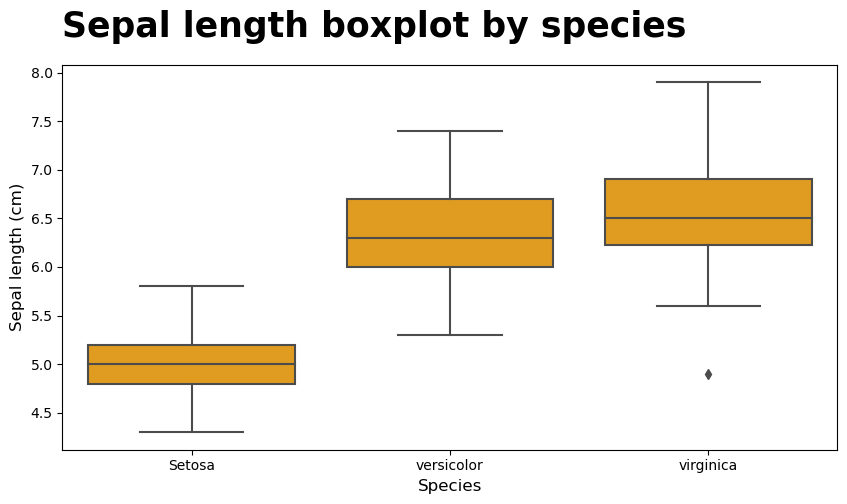

In [62]:
plt.figure(figsize=(10,5))

sns.boxplot(data = data,  x = 'target', y= 'sepal length (cm)', color = 'orange')

plt.title('Sepal length boxplot by species', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.ylabel('Sepal length (cm)', size= 12)
plt.xlabel('Species', size= 12)

plt.show()

Visualy we can see that the difference between the virginica and versicolor has decreased. But, is the difference still significant?

In [64]:
virginica_alt = data[data['target'] == 'virginica']['sepal length (cm)']
versicolor_alt = data[data['target'] == 'versicolor']['sepal length (cm)']

In [67]:
# Calculating 
observed_test_stat = virginica_alt.median() - versicolor_alt.median()
observed_test_stat

0.1999999999999993

In [68]:
# Number of permutations
n_permutations = 50000
# List of permutation test-statistic
list_permutations = []
# List of probability (bootstrap_test_stat >= oberseved_test_stat)
stat = []
# Sample bootstrap means from 1 & 2
sample_medians = []
permutation_array = np.concatenate((virginica_alt.values, versicolor_alt.values)) # Concatenating two populations


for _ in range(n_permutations):

    # Generate sample permutation
    l = np.random.permutation(permutation_array)
    
    # Splitting the sample permutation in the two population
    sample_1 = l[:len(virginica_alt)]
    sample_2 = l[len(virginica_alt):]
    
    # Calculating Sample boostrap mean for both population
    median_1 = np.median(sample_1)
    median_2 = np.median(sample_2)
    
    # Appending the sample boostrap median
    sample_medians.append((median_1, median_2))
    
    # Calculate the boostrap test-statistic
    bott_test_stat = median_1 - median_2
    
    # Append the boostrap test-statistic
    list_permutations.append(bott_test_stat)
      
    # Comparison
    stat.append(abs(bott_test_stat) >= abs(observed_test_stat))

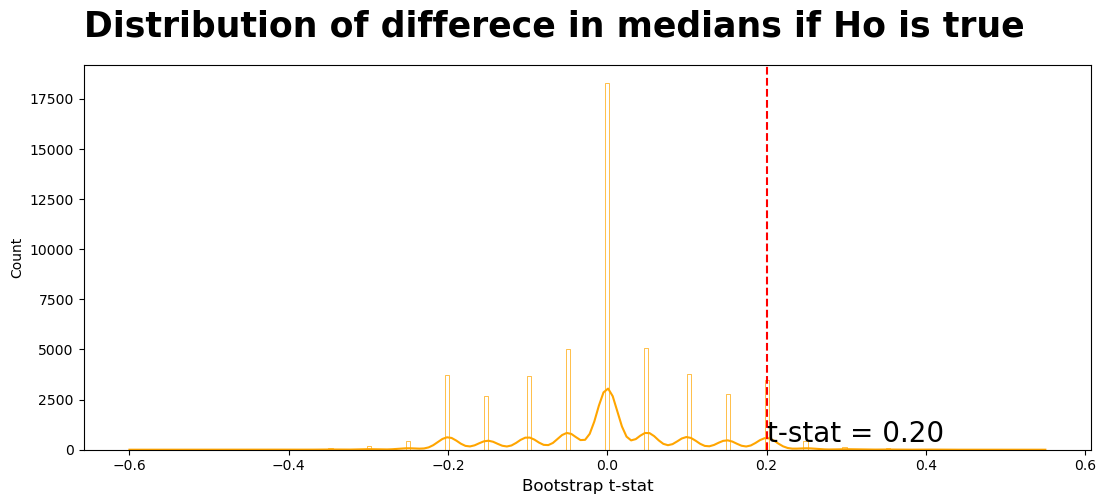

In [69]:
plt.figure(figsize=(13,5))

sns.histplot(x =list_permutations, color= 'orange', fill = False, kde= True)

plt.title('Distribution of differece in medians if Ho is true', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.xlabel('Bootstrap t-stat', size= 12)
plt.axvline(x=observed_test_stat, color='red', linestyle='--', label='t-Statistic')
plt.text(observed_test_stat, 100, f't-stat = {observed_test_stat:.2f}', size=20, color='black', verticalalignment='bottom', horizontalalignment='left')

plt.show()

In [70]:
# The variable stat contains the comparison |bootstrap test stat| >= |observed test stat|
print(f'There are {np.array(stat).sum()} permutation t-stat that are greater or equal to the observed t-test')

There are 8669 permutation t-stat that are greater or equal to the observed t-test


In [71]:
p_value = np.array(stat).sum() / n_permutations
p_value

0.17338

**Result:** Fail to Reject $H_0$

**Interpretation:**  The calculated p-value of approximately 17.3% suggests that there is not enough evidence to support a significant difference between the median sepal length (cm) of virginica and versicolor species. Therefore, we cannot conclude that there is a meaningful difference in the sepal length medians between the two species, and it is likely that both medians are approximately the same.